# Aim of this notebook

* To construct the singular curve of universal type to finalize the solution of the optimal control problem

# Preamble

In [21]:
from sympy import *
init_printing(use_latex='mathjax')

# Plotting
%matplotlib inline
## Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
## Import modules for plotting and data analysis
import matplotlib.pyplot as plt
from matplotlib import gridspec,rc,colors
import matplotlib.ticker as plticker
## Parameters for seaborn plots
import seaborn as sns
sns.set(style='white',font_scale=1.25,
        rc={"xtick.major.size": 6, "ytick.major.size": 6,
            'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Times']})

import pandas as pd
pd.set_option('mode.chained_assignment',None)

import numpy as np
from scipy.optimize import fsolve, root
from scipy.integrate import ode
backend = 'dopri5'
import warnings

# Timer
import time

from copy import deepcopy

from itertools import cycle
palette_size = 10;
clrs = sns.color_palette("Reds",palette_size)
iclrs = cycle(clrs) # iterated colors

clrs0 = sns.color_palette("Set1",palette_size)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Parameter values

* Birth rate and const of downregulation are defined below in order to fit some experim. data

In [2]:
d = .13 # death rate
c = .04 # cost of resistance
α = .3 # low equilibrium point at expression of the main pathway (high equilibrium is at one)
θ = .45 # threshold value for the expression of the main pathway
κ = 40 # robustness parameter
L = .2 # parameter used to model the effect of treatment (see the line below)

* Symbolic variables - the list insludes μ & μbar, because they will be varied later

In [3]:
σ, φ0, φ, x, μ, μbar = symbols('sigma, phi0, phi, x, mu, mubar')

* Main functions

In [4]:
A = 1-σ*(1-θ)*(1-L)
Θ = θ+σ*(1-θ)*L
Eminus = (α*A-Θ)**2/2
ΔE = A*(1-α)*((1+α)*A/2-Θ)
ΔEf = lambdify(σ,ΔE)

* Birth rate and cost of downregulation

In [5]:
b = (0.1*(exp(κ*(ΔEf(1)))+1)-0.14*(exp(κ*ΔEf(0))+1))/(exp(κ*ΔEf(1))-exp(κ*ΔEf(0))) # birth rate
χ = 1-(0.14*(exp(κ*ΔEf(0))+1)-b*exp(κ*ΔEf(0)))/b
b, χ

(0.140154784911281, 0.299759386875464)

* Hamiltonian *H* and a part of it ρ that includes the control variable σ

In [6]:
h = b*(χ/(exp(κ*ΔE)+1)*(1-x)+c*x)
H = -φ0 + φ*(b*(χ/(exp(κ*ΔE)+1)-c)*x*(1-x)+μ*(1-x)/(exp(κ*ΔE)+1)-μbar*exp(-κ*Eminus)*x) + h
ρ = (φ*(b*χ*x+μ)+b*χ)/(exp(κ*ΔE)+1)*(1-x)-φ*μbar*exp(-κ*Eminus)*x
ρ1 = (φ*(b*χ*x+μ)+b*χ)/(exp(κ*ΔE)+1)*(1-x)
ρ2 = φ*μbar*exp(-κ*Eminus)*x
H, ρ

⎛  ⎛                                                                       2  
⎜  ⎜                μ⋅(-x + 1)                        -20⋅(-0.242⋅σ - 0.15)   
⎜φ⋅⎜───────────────────────────────────────── - μ̅⋅x⋅ℯ                       +
⎜  ⎜ 40⋅(-0.396⋅σ + 0.2)⋅(-0.308⋅σ + 0.7)                                     
⎝  ⎝ℯ                                     + 1                                 

                                                                              
   ⎛                                   0.042012712392668            ⎞         
 x⋅⎜-0.00560619139645122 + ─────────────────────────────────────────⎟⋅(-x + 1)
   ⎜                        40⋅(-0.396⋅σ + 0.2)⋅(-0.308⋅σ + 0.7)    ⎟         
   ⎝                       ℯ                                     + 1⎠         

⎞                                                                             
⎟                                        0.042012712392668⋅(-x + 1)           
⎟ - φ₀ + 0.00560619139645122⋅x + ─────────────────

* Same but for no treatment (σ = 0)

In [7]:
h0 = h.subs(σ,0)
H0 = H.subs(σ,0)
ρ0 = ρ.subs(σ,0)
H0, ρ0

(φ⋅(0.00368423989943599⋅μ⋅(-x + 1) - 0.637628151621773⋅μ̅⋅x - 0.00545140648517
063⋅x⋅(-x + 1)) - φ₀ + 0.00545140648517063⋅x + 0.000154784911280596, -0.637628
151621773⋅μ̅⋅φ⋅x + 0.00368423989943599⋅(-x + 1)⋅(φ⋅(μ + 0.042012712392668⋅x) +
 0.042012712392668))

* Machinery: definition of the Poisson brackets

In [8]:
PoissonBrackets = lambda H1, H2: diff(H1,x)*diff(H2,φ)-diff(H1,φ)*diff(H2,x)

* Necessary functions and defining the right hand side of dynamical equations

In [9]:
ρf = lambdify((x,φ,σ,μ,μbar),ρ)
ρ1f = lambdify((x,φ,σ,μ,μbar),ρ1)
ρ2f = lambdify((x,φ,σ,μ,μbar),ρ2)
ρ0f = lambdify((x,φ,μ,μbar),ρ0)
dxdτ = lambdify((x,φ,σ,μ,μbar),-diff(H,φ))
dφdτ = lambdify((x,φ,σ,μ,μbar),diff(H,x))
dVdτ = lambdify((x,σ),h)
dρdσ = lambdify((σ,x,φ,μ,μbar),diff(ρ,σ))
dδρdτ = lambdify((x,φ,σ,μ,μbar),-PoissonBrackets(ρ0-ρ,H))
def ode_rhs(t,state,μ,μbar):
    x, φ, V, δρ = state
    σs = [0,1]
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    if ρf(x,φ,σstar,μ,μbar) < ρ0f(x,φ,μ,μbar):
        sgm = 0
    else:
        sgm = σstar
    return [dxdτ(x,φ,sgm,μ,μbar),dφdτ(x,φ,sgm,μ,μbar),dVdτ(x,sgm),dδρdτ(x,φ,σstar,μ,μbar)]
def σstarf(x,φ,μ,μbar):
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    if ρf(x,φ,σstar,μ,μbar) < ρ0f(x,φ,μ,μbar):
        sgm = 0
    else:
        sgm = σstar
    return sgm

In [10]:
def get_primary_field(name, experiment,μ,μbar):
    solutions = {}
    solver = ode(ode_rhs).set_integrator(backend)
    τ0 = experiment['τ0']
    tms = np.linspace(τ0,experiment['T_end'],1e3+1)
    for x0 in experiment['x0']:
        δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
        solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
        sol = []; k = 0;
        while (solver.t < experiment['T_end']) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
            solver.integrate(tms[k])
            sol.append([solver.t]+list(solver.y))
            k += 1
        solutions[x0] = {'solution': sol}
    for x0, entry in solutions.items():
        entry['τ'] = [entry['solution'][j][0] for j in range(len(entry['solution']))]
        entry['x'] = [entry['solution'][j][1] for j in range(len(entry['solution']))]
        entry['φ'] = [entry['solution'][j][2] for j in range(len(entry['solution']))]
        entry['V'] = [entry['solution'][j][3] for j in range(len(entry['solution']))]
        entry['δρ'] = [entry['solution'][j][4] for j in range(len(entry['solution']))]
    return solutions
def get_δρ_value(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    while (solver.t < tme) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tme)
        sol = [solver.t]+list(solver.y)
    return solver.y[3]
def get_δρ_ending(params,μ,μbar):
    tme, x0 = params
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (_k<len(tms)):# and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    #print(sol)
    return(sol[0][3],(sol[1][3]-sol[0][3])/δτ)
def get_state(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (solver.t < tms[-1]) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    return(list(sol[0])+[(sol[1][3]-sol[0][3])/δτ])

# Machinery for the universal line

* To find the universal singular curve we need to define two parameters

In [11]:
γ0 = PoissonBrackets(PoissonBrackets(H,H0),H)
γ1 = PoissonBrackets(PoissonBrackets(H0,H),H0)

* The dynamics

In [12]:
dxdτSingExpr = -(γ0*diff(H0,φ)+γ1*diff(H,φ))/(γ0+γ1)
dφdτSingExpr = (γ0*diff(H0,x)+γ1*diff(H,x))/(γ0+γ1)
dVdτSingExpr = (γ0*h0+γ1*h)/(γ0+γ1)
σSingExpr = γ1*σ/(γ0+γ1)

* Machinery for Python: lambdify the functions above

In [13]:
dxdτSing = lambdify((x,φ,σ,μ,μbar),dxdτSingExpr)
dφdτSing = lambdify((x,φ,σ,μ,μbar),dφdτSingExpr)
dVdτSing = lambdify((x,φ,σ,μ,μbar),dVdτSingExpr)
σSing = lambdify((x,φ,σ,μ,μbar),σSingExpr)

In [14]:
def ode_rhs_Sing(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτSing(x,φ,σstar,μ,μbar)]
def get_universal_curve(end_point,tmax,Nsteps,μ,μbar):
    tms =  np.linspace(end_point[0],tmax,Nsteps);
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tms[-1]):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_σ_universal(tme,end_point,μ,μbar):
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tme+δτ):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    x, φ = sol[0][:2]
    sgm = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-(sol[1][0]-sol[0][0])/δτ,θ/2)[0]
    return sgm
def get_state_universal(tme,end_point,μ,μbar):
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)

In [15]:
def ode_rhs_with_σstar(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σ = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σ = 1.;
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def ode_rhs_with_given_σ(t,state,σ,μ,μbar):
    x, φ, V = state
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def get_trajectory_with_σstar(starting_point,tmax,Nsteps,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,Nsteps)
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_trajectory_with_given_σ(starting_point,tmax,Nsteps,σ,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,100)
    solver = ode(ode_rhs_with_given_σ).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(σ,μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_state_with_σstar(tme,starting_point,μ,μbar):
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:4],starting_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)
def get_finalizing_point_from_universal_curve(tme,tmx,end_point,μ,μbar):
    unv_point = get_state_universal(tme,end_point,μ,μbar)
    return get_state_with_σstar(tmx,unv_point,μ,μbar)[1]

# Field of optimal trajectories as the solution of the Bellman equation

* μ & μbar are varied by *T* and *T*bar ($\mu=1/T$ and $\bar\mu=1/\bar{T}$)

In [16]:
tmx = 720.
end_switching_curve = {'t': 24., 'x': .9/.8} 
# for Τ, Τbar in zip([28]*5,[14,21,28,35,60]):
Τ = 28; Τbar = 60
μ = 1./Τ; μbar = 1./Τbar
print("Parameters: μ = %.5f, μbar = %.5f"%(μ,μbar))
end_switching_curve['t'], end_switching_curve['x'] = fsolve(get_δρ_ending,(end_switching_curve['t'],.8*end_switching_curve['x']),args=(μ,μbar),xtol=1.0e-12)
end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
print("Ending point for the switching line: τ = %.1f days, x = %.1f%%" % (end_point[0], end_point[1]*100))
print("Checking the solution - should give zero values: ")
print(get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar))
print("* Constructing the primary field")
primary_field1 = []
experiments = {
    'sol1': { 'T_end': tmx, 'τ0': 0., 'x0': list(np.linspace(0,end_switching_curve['x']-(1e-3),7)) } }
for name, values in experiments.items():
    primary_field1.append(get_primary_field(name,values,μ,μbar))
primary_field2 = []
experiments = {
    'sol1': { 'T_end': tmx, 'τ0': 0., 'x0': list(np.linspace(end_switching_curve['x']+(1e-6),1.,7)) } }
for name, values in experiments.items():
    primary_field2.append(get_primary_field(name,values,μ,μbar))
print("* Constructing the switching curve")
switching_curve = []
x0s = np.linspace(end_switching_curve['x'],1,21); _y = end_switching_curve['t']

for x0 in x0s:
    tme = fsolve(get_δρ_value,_y,args=(x0,μ,μbar))[0]
    if (tme>0):
        switching_curve = switching_curve+[[tme,get_state(tme,x0,μ,μbar)[0]]]
        _y = tme
print("* Constructing the universal curve")
universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
print("* Finding the last characteristic")
#time0 = time.time()
tuniv = fsolve(get_finalizing_point_from_universal_curve,tmx-40.,args=(tmx,end_point,μ,μbar,))[0]
#print("The proccess to find the last characteristic took %0.1f minutes" % ((time.time()-time0)/60.))
univ_point = get_state_universal(tuniv,end_point,μ,μbar)
print("The last point on the universal line:")
print(univ_point)
last_trajectory = get_trajectory_with_σstar(univ_point,tmx,50,μ,μbar)
print("Final state:")
final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
print(final_state)
print("Fold-change in tumor size: %.2f"%(exp((b-d)*tmx-final_state[-1])))

Parameters: μ = 0.03571, μbar = 0.01667
Ending point for the switching line: τ = 20.9 days, x = 77.1%
Checking the solution - should give zero values: 
(2.852599443280406e-16, 3.995887647659395e-17)
* Constructing the primary field
* Constructing the switching curve
* Constructing the universal curve
* Finding the last characteristic
The last point on the universal line:
[688.6199123109664, 0.7713878275867576, -0.40997313020945475, 5.6229521162957194]
Final state:
[720.0, 3.3478081418181205e-13, -0.9389845522405276, 6.385684997465624]
Fold-change in tumor size: 2.52


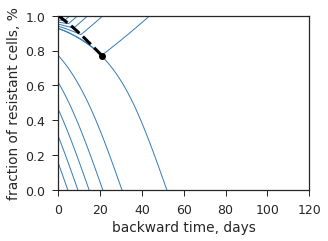

In [23]:
# Plotting
plt.rcParams['figure.figsize'] = (4.5, 3.2)
_k = 0
for solutions in primary_field1:
    for x0, entry in solutions.items():
        plt.plot(entry['τ'], entry['x'], '-', linewidth=1, color=clrs0[1])
        _k += 1
_k = 0
for solutions in primary_field2:
    for x0, entry in solutions.items():
        plt.plot(entry['τ'], entry['x'], '-', linewidth=1, color=clrs0[1])
        _k += 1
plt.plot([x[0] for x in switching_curve],[x[1] for x in switching_curve],linewidth=3,color="k",zorder=4,linestyle="dashed")
plt.plot([end_point[0]],[end_point[1]],marker='o',color="black",zorder=4)

plt.xlim([0,120]); plt.ylim([0,1]);
plt.xlabel("backward time, days"); plt.ylabel("fraction of resistant cells, %")
# plt.show()
plt.savefig("../figures/draft/AppendixFig2-0.pdf",format='pdf',bbox_inches='tight')

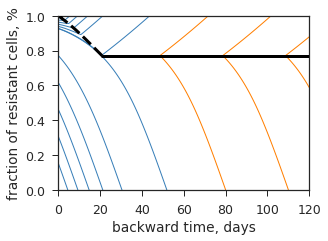

In [24]:
# Plotting
plt.rcParams['figure.figsize'] = (4.5, 3.2)
_k = 0
for solutions in primary_field1:
    for x0, entry in solutions.items():
        plt.plot(entry['τ'], entry['x'], '-', linewidth=1, color=clrs0[1])
        _k += 1
_k = 0
for solutions in primary_field2:
    for x0, entry in solutions.items():
        plt.plot(entry['τ'], entry['x'], '-', linewidth=1, color=clrs0[1])
        _k += 1
plt.plot([x[0] for x in switching_curve],[x[1] for x in switching_curve],linewidth=3,color="k",zorder=4,linestyle="dashed")
# plt.plot([end_point[0]],[end_point[1]],marker='o',color="black",zorder=4)
plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=3,color="k",zorder=3)
for tend in [80,110,140]:
    tuniv = fsolve(get_finalizing_point_from_universal_curve,tend-20.,args=(tend,end_point,μ,μbar,))[0]
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    trajectory = get_trajectory_with_σstar(univ_point,tend,50,μ,μbar)
    plt.plot([x[0] for x in trajectory],[x[1] for x in trajectory],linewidth=1,color=clrs0[4])
    trajectory = get_trajectory_with_given_σ(univ_point,tend+20,100,0,μ,μbar)
    plt.plot([x[0] for x in trajectory],[x[1] for x in trajectory],linewidth=1,color=clrs0[4])
plt.xlim([0,120]); plt.ylim([0,1]);
plt.xlabel("backward time, days"); plt.ylabel("fraction of resistant cells, %")
# plt.show()
plt.savefig("../figures/draft/AppendixFig2-1.pdf",format='pdf',bbox_inches='tight')

In [27]:
#ρf = lambdify((x,φ,σ,μ,μbar),ρ)

100


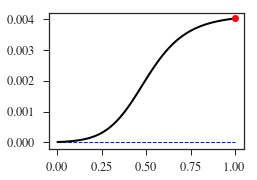

In [20]:
# Plotting
plt.rcParams['figure.figsize'] = (3.5, 2.5)

σs = np.linspace(0,1,101)
plt.plot(σs,[ρf(.9,0,σ,μ,μbar) for σ in σs],linewidth=2,color="k")
σimx = np.argmax([ρf(.9,0,σ,μ,μbar) for σ in σs])
print(σimx)
plt.plot(σs[σimx],[ρf(.9,0,σs[σimx],μ,μbar)],'ro')
plt.plot(σs,[ρ1f(.9,0,σ,μ,μbar) for σ in σs],'g--',linewidth=1,zorder=-5)
plt.plot(σs,[ρ2f(.9,0,σ,μ,μbar) for σ in σs],'b--',linewidth=1,zorder=-5)
plt.ylim([-.0002,.0042]);
plt.savefig("../figures/draft/AppendixFig1-A.pdf",format='pdf',bbox_inches='tight')

Terminal point:  0.0 0.927744797395 0.0
12.24 0.855402663434 -0.294885607032
87


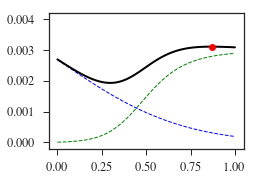

In [21]:
fig, ax = plt.subplots()
for solution in primary_field2:
    k = 0
    for x0, entry in solution.items():
        if (k==0):
            print("Terminal point: ",entry['τ'][0],entry['x'][0],entry['φ'][0])
            kk = 17
            print(entry['τ'][kk],entry['x'][kk],entry['φ'][kk])
            ρyy = [ρf(entry['x'][kk],entry['φ'][kk],σ,μ,μbar) for σ in σs]
            plt.plot(σs,ρyy,linewidth=2,color="k")
            σimx = np.argmax(ρyy)
            print(σimx)
            plt.plot(σs[σimx],ρyy[σimx],'ro')
            plt.plot(σs,[ρ1f(entry['x'][kk],entry['φ'][kk],σ,μ,μbar) for σ in σs],'g--',linewidth=1,zorder=-5)
            plt.plot(σs,[-ρ2f(entry['x'][kk],entry['φ'][kk],σ,μ,μbar) for σ in σs],'b--',linewidth=1,zorder=-5)
            plt.ylim([-.0002,.0042]);
            break
        k = k + 1
plt.savefig("../figures/draft/AppendixFig1-B.pdf",format='pdf',bbox_inches='tight')

Terminal point:  0.0 0.927744797395 0.0
28.799999999999997 0.848652079259 -0.342443947212
0


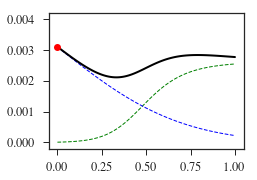

In [22]:
fig, ax = plt.subplots()
for solution in primary_field2:
    k = 0
    for x0, entry in solution.items():
        if (k==0):
            print("Terminal point: ",entry['τ'][0],entry['x'][0],entry['φ'][0])
            kk = 40
            print(entry['τ'][kk],entry['x'][kk],entry['φ'][kk])
            ρyy = [ρf(entry['x'][kk],entry['φ'][kk],σ,μ,μbar) for σ in σs]
            plt.plot(σs,ρyy,linewidth=2,color="k")
            σimx = np.argmax(ρyy)
            print(σimx)
            plt.plot(σs[σimx],ρyy[σimx],'ro')
            plt.plot(σs,[ρ1f(entry['x'][kk],entry['φ'][kk],σ,μ,μbar) for σ in σs],'g--',linewidth=1,zorder=-5)
            plt.plot(σs,[-ρ2f(entry['x'][kk],entry['φ'][kk],σ,μ,μbar) for σ in σs],'b--',linewidth=1,zorder=-5)
            plt.ylim([-.0002,.0042]);
            break
        k = k + 1
plt.savefig("../figures/draft/AppendixFig1-C.pdf",format='pdf',bbox_inches='tight')

Point on the universal curve:  50.04971965940882 0.77138782657 -0.409973129589
82


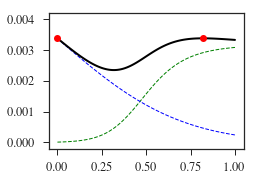

In [23]:
fig, ax = plt.subplots()
kk = 1
xu = universal_curve[kk][1]
φu = universal_curve[kk][2]
print("Point on the universal curve: ",universal_curve[kk][0],xu,φu)

ρyy = [ρf(xu,φu,σ,μ,μbar) for σ in σs]
plt.plot(σs,ρyy,linewidth=2,color="k")
σimx = np.argmax(ρyy)
print(σimx)
plt.plot(σs[σimx],ρyy[σimx],'ro')
plt.plot([0],ρyy[σimx],'ro')
plt.plot(σs,[ρ1f(xu,φu,σ,μ,μbar) for σ in σs],'g--',linewidth=1,zorder=-5)
plt.plot(σs,[-ρ2f(xu,φu,σ,μ,μbar) for σ in σs],'b--',linewidth=1,zorder=-5)
plt.ylim([-.0002,.0042]);
# ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.savefig("../figures/draft/AppendixFig1-D.pdf",format='pdf',bbox_inches='tight')

# Preparation for second figure

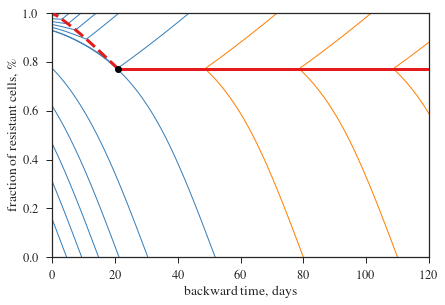

In [24]:
# Plotting
plt.rcParams['figure.figsize'] = (6.75, 4.5)
_k = 0
for solutions in primary_field1:
    for x0, entry in solutions.items():
        plt.plot(entry['τ'], entry['x'], '-', linewidth=1, color=clrs0[1])
        _k += 1
_k = 0
for solutions in primary_field2:
    for x0, entry in solutions.items():
        plt.plot(entry['τ'], entry['x'], '-', linewidth=1, color=clrs0[1])
        _k += 1
plt.plot([x[0] for x in switching_curve],[x[1] for x in switching_curve],linewidth=3,color=clrs0[0],zorder=4,linestyle="dashed")
plt.plot([end_point[0]],[end_point[1]],marker='o',color="black",zorder=4)
plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=3,color=clrs0[0],zorder=3)
for tend in [80,110,140]:
    tuniv = fsolve(get_finalizing_point_from_universal_curve,tend-20.,args=(tend,end_point,μ,μbar,))[0]
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    trajectory = get_trajectory_with_σstar(univ_point,tend,50,μ,μbar)
    plt.plot([x[0] for x in trajectory],[x[1] for x in trajectory],linewidth=1,color=clrs0[4])
    trajectory = get_trajectory_with_given_σ(univ_point,tend+20,100,0,μ,μbar)
    plt.plot([x[0] for x in trajectory],[x[1] for x in trajectory],linewidth=1,color=clrs0[4])
plt.xlim([0,120]); plt.ylim([0,1]);
plt.xlabel("backward time, days"); plt.ylabel("fraction of resistant cells, \%")
plt.show()

1.7519999999999998


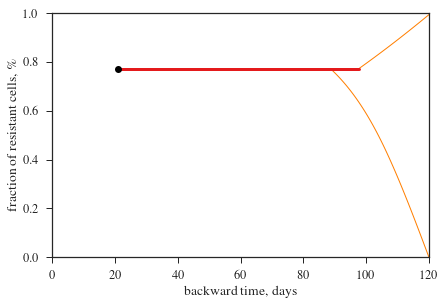

In [35]:
plt.rcParams['figure.figsize'] = (6.75, 4.5)

_k = 0
for solutions in primary_field1:
    for x0, entry in solutions.items():
        if _k==5:
            sol = [[1,τ,σstarf(x,φ,μ,μbar),x,exp((b-d)*τ-V)] for τ,x,φ,V in zip(entry['τ'],entry['x'],entry['φ'],entry['V'])]
        if _k==6:
            trajectory_thr = [[τ,x,φ,V] for τ,x,φ,V in zip(entry['τ'],entry['x'],entry['φ'],entry['V'])]
            sol += [[0,τ,σstarf(x,φ,μ,μbar),x,exp((b-d)*τ-V)] for τ,x,φ,V in trajectory_thr]
            T0 = max([x[0] for x in trajectory_thr]) 
        _k += 1
#plt.plot(τ1, x1, '-', linewidth=1, color=clrs0[1])
#plt.plot(τthr, xthr, '--', linewidth=1, color=clrs0[1])
print(T0/30.)


plt.plot([end_point[0]],[end_point[1]],marker='o',color="black",zorder=4)
for tend in [120]:
    tuniv = fsolve(get_finalizing_point_from_universal_curve,tend-20.,args=(tend,end_point,μ,μbar,))[0]
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    trajectory = get_trajectory_with_σstar(univ_point,tend,50,μ,μbar)
    plt.plot([x[0] for x in trajectory],[x[1] for x in trajectory],linewidth=1,color=clrs0[4])
    sol += [[3,τ,σstarf(x,φ,μ,μbar),x,exp((b-d)*τ-V)] for τ,x,φ,V in trajectory]
    universal_curve = get_universal_curve(end_point,univ_point[0],50,μ,μbar)
    plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=3,color=clrs0[0],zorder=3)
    sol = [[3,τ,get_σ_universal(τ,end_point,μ,μbar),x,exp((b-d)*τ-V)] for τ,x,φ,V in universal_curve] + sol
    trajectory = get_trajectory_with_σstar([0,end_switching_curve['x'],0,0],end_point[0],50,μ,μbar)
    sol = [[3,τ,σstarf(x,φ,μ,μbar),x,exp((b-d)*τ-V)] for τ,x,φ,V in trajectory] + sol
for tend in [129]:
    tuniv = fsolve(get_finalizing_point_from_universal_curve,tend-20.,args=(tend,end_point,μ,μbar,))[0]
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    trajectory = get_trajectory_with_σstar(univ_point,tend,50,μ,μbar)
    trajectory = get_trajectory_with_given_σ(univ_point,tend+20,100,0,μ,μbar)
    plt.plot([x[0] for x in trajectory],[x[1] for x in trajectory],linewidth=1,color=clrs0[4])
    sol += [[2,τ,σstarf(x,φ,μ,μbar),x,exp((b-d)*τ-V)] for τ,x,φ,V in trajectory]
    universal_curve = get_universal_curve(end_point,univ_point[0],50,μ,μbar)
    plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=3,color=clrs0[0],zorder=3)
    sol = [[2,τ,get_σ_universal(τ,end_point,μ,μbar),x,exp((b-d)*τ-V)] for τ,x,φ,V in universal_curve] + sol
    trajectory = get_trajectory_with_σstar([0,end_switching_curve['x'],0,0],end_point[0],50,μ,μbar)
    sol = [[2,τ,σstarf(x,φ,μ,μbar),x,exp((b-d)*τ-V)] for τ,x,φ,V in trajectory] + sol
plt.xlim([0,120]); plt.ylim([0,1]);
plt.xlabel("backward time, days"); plt.ylabel("fraction of resistant cells, \%")
plt.show()

In [38]:
pd.DataFrame(sol).to_csv('../figures/draft/Fig4-trjs_optimal.csv',index=False,header=False)